<a href="https://colab.research.google.com/github/saritmaitra/Markov_Model/blob/master/Markov_regime_switching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hmmlearn
!pip install pyforest
from pyforest import *
import datetime, pickle, copy
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import matplotlib.pyplot as plt
%matplotlib inline  
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
!pip install quandl
import quandl
plt.style.use('ggplot')
from statistics import variance 
from random import randint
import scipy as sp
from scipy import stats
!pip install ffn
import ffn
from matplotlib import cm
import numpy as np
%matplotlib inline
from sklearn.preprocessing import scale # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, r2_score
import sklearn.mixture as mix
import math, pickle
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
import warnings
import seaborn as sns
sns.set()
from hmmlearn.hmm import GaussianHMM
from random import randint
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl
warnings.filterwarnings("ignore")

     |████████████████████████████████| 378kB 7.2MB/s 
  Created wheel for pyforest: filename=pyforest-1.0.3-py2.py3-none-any.whl size=13716 sha256=96148af47a8153042c8ced9165522c74d8b4980c54d6ff4fc1f59b4be189ea39
  Stored in directory: /root/.cache/pip/wheels/af/0b/39/340a7f15fc8d4ff5ab50847b28789afea04452a9d51b9721b5
Successfully built pyforest


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas_datareader as web
df = web.DataReader('^IXIC', data_source = 'yahoo', start = '2000-01-01')

print(f'Nasdaq Composite Index:')
print(df.head())
print('\n')
print(df.shape)

Nasdaq Composite Index:
                   High          Low         Open        Close      Volume    Adj Close
Date                                                                                   
2000-01-03  4192.189941  3989.709961  4186.189941  4131.149902  1510070000  4131.149902
2000-01-04  4073.250000  3898.229980  4020.000000  3901.689941  1511840000  3901.689941
2000-01-05  3924.209961  3734.870117  3854.350098  3877.540039  1735670000  3877.540039
2000-01-06  3868.760010  3715.620117  3834.439941  3727.129883  1598320000  3727.129883
2000-01-07  3882.669922  3711.090088  3711.090088  3882.620117  1634930000  3882.620117


(5322, 6)


In [3]:
data = df[['High','Low','Open','Adj Close', 'Volume']]
data['returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift())
data.dropna(inplace=True)
data.tail()

,High,Low,Open,Adj Close,Volume,returns
Date,,,,,,
2021-02-22,13757.059570,13530.959961,13714.200195,13533.049805,6435100000,-0.024915
2021-02-23,13526.089844,13003.980469,13262.610352,13465.200195,7482840000,-0.005026
2021-02-24,13607.360352,13286.589844,13400.250000,13597.969727,5793430000,0.009812
2021-02-25,13602.860352,13066.379883,13512.639648,13119.429688,6335240000,-0.035826
2021-02-26,13368.059570,13024.530273,13232.900391,13192.349609,5883880000,0.005543


count     5321.000000
mean      3860.713530
std       2496.539951
min       1114.109985
25%       2110.419922
50%       2738.629883
75%       4945.890137
max      14095.469727
Name: Adj Close, dtype: float64

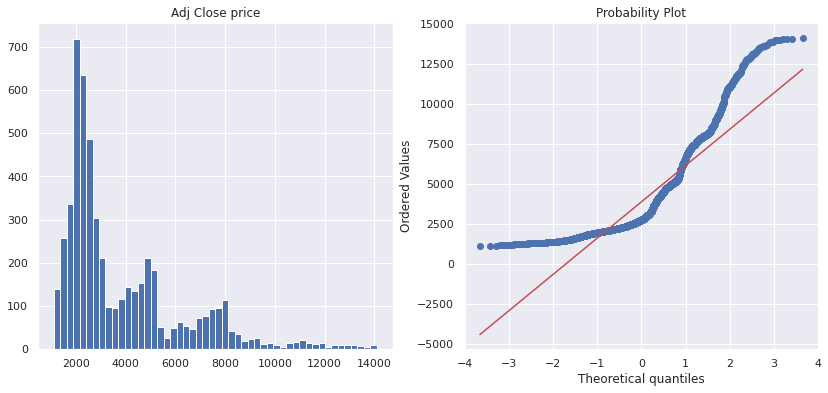

In [4]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['Adj Close'].hist(bins=50)
plt.title('Adj Close price')
plt.subplot(1,2,2)
stats.probplot(data['Adj Close'], plot=plt);
data['Adj Close'].describe().T

In [5]:
from statsmodels.tsa.stattools import adfuller

adfuller(data['returns'].dropna())

(-16.772045504408293,
 1.2845642646052612e-29,
 17,
 5303,
 {'1%': -3.4315837296252485,
  '10%': -2.567060199830317,
  '5%': -2.8620851819422586},
 -28857.24944867193)

In [6]:
data['state'] = data['returns'].apply(lambda x: 'up' if (x > 0.001)\
else ('down' if (x < -0.001)\
else 'no_change'))
data.tail()

,High,Low,Open,Adj Close,Volume,returns,state
Date,,,,,,,
2021-02-22,13757.059570,13530.959961,13714.200195,13533.049805,6435100000,-0.024915,down
2021-02-23,13526.089844,13003.980469,13262.610352,13465.200195,7482840000,-0.005026,down
2021-02-24,13607.360352,13286.589844,13400.250000,13597.969727,5793430000,0.009812,up
2021-02-25,13602.860352,13066.379883,13512.639648,13119.429688,6335240000,-0.035826,down
2021-02-26,13368.059570,13024.530273,13232.900391,13192.349609,5883880000,0.005543,up


In [7]:
data['prev_state'] = data['state'].shift(1)
data.tail()

,High,Low,Open,Adj Close,Volume,returns,state,prev_state
Date,,,,,,,,
2021-02-22,13757.059570,13530.959961,13714.200195,13533.049805,6435100000,-0.024915,down,no_change
2021-02-23,13526.089844,13003.980469,13262.610352,13465.200195,7482840000,-0.005026,down,down
2021-02-24,13607.360352,13286.589844,13400.250000,13597.969727,5793430000,0.009812,up,down
2021-02-25,13602.860352,13066.379883,13512.639648,13119.429688,6335240000,-0.035826,down,up
2021-02-26,13368.059570,13024.530273,13232.900391,13192.349609,5883880000,0.005543,up,down


In [8]:
state_space = data[['prev_state', 'state']]
state_space_matrix = data.groupby(['prev_state', 'state']).size().unstack()
state_space_matrix

state,down,no_change,up
prev_state,,,
down,922,153,1129
no_change,184,43,238
up,1097,269,1285


In [9]:
print(state_space_matrix.sum())

state
down         2203
no_change     465
up           2652
dtype: int64


In [10]:
transition_matrix = state_space_matrix.apply(lambda x: x/float(x.sum()), axis=1)
transition_matrix

state,down,no_change,up
prev_state,,,
down,0.418330,0.069419,0.512250
no_change,0.395699,0.092473,0.511828
up,0.413806,0.101471,0.484723


In [11]:
print(transition_matrix.sum(axis=1))

prev_state
down         1.0
no_change    1.0
up           1.0
dtype: float64


In [12]:
t0 = transition_matrix.copy()
t1 = round(t0.dot(t0), 4)
t1

state,down,no_change,up
prev_state,,,
down,0.4144,0.0874,0.4981
no_change,0.4139,0.0880,0.4981
up,0.4138,0.0873,0.4989


In [13]:
t2 = round(t0.dot(t1), 4)
t2

state,down,no_change,up
prev_state,,,
down,0.4141,0.0874,0.4985
no_change,0.4140,0.0874,0.4985
up,0.4141,0.0874,0.4985


In [14]:
t3 = round(t0.dot(t2), 4)
t3

state,down,no_change,up
prev_state,,,
down,0.4141,0.0874,0.4985
no_change,0.4141,0.0874,0.4985
up,0.4141,0.0874,0.4985


In [15]:
pd.DataFrame(np.linalg.matrix_power(t0,4))

<IPython.core.display.Javascript object>

,0,1,2
0,0.414097,0.087412,0.498491
1,0.414097,0.087412,0.498491
2,0.414097,0.087412,0.498491


In [16]:
# find the equilibrium matrix
i=1
a= t0.copy()
b = t0.dot(t0)
while(not(a.equals(b))):
  print('iteration number:' +str(i))
  i += 1
  a = b.copy()
  b = b.dot(t0)

iteration number:1
iteration number:2
iteration number:3
iteration number:4
iteration number:5
iteration number:6
iteration number:7
iteration number:8
iteration number:9
iteration number:10
iteration number:11


In [17]:
from pprint import pprint 

# create a function that maps transition probability dataframe 
# to markov edges and weights

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(transition_matrix)
pprint(edges_wts)

{('down', 'down'): 0.41833030852994557,
 ('down', 'no_change'): 0.06941923774954628,
 ('down', 'up'): 0.5122504537205081,
 ('no_change', 'down'): 0.3956989247311828,
 ('no_change', 'no_change'): 0.09247311827956989,
 ('no_change', 'up'): 0.5118279569892473,
 ('up', 'down'): 0.41380611090154656,
 ('up', 'no_change'): 0.1014711429649189,
 ('up', 'up'): 0.4847227461335345}


Nodes:
['down', 'no_change', 'up']

Edges:


<IPython.core.display.Javascript object>

           0          1                                                  2
0       down       down  {'weight': 0.41833030852994557, 'label': 0.418...
1       down  no_change  {'weight': 0.06941923774954628, 'label': 0.069...
2       down         up  {'weight': 0.5122504537205081, 'label': 0.5122...
3  no_change       down  {'weight': 0.3956989247311828, 'label': 0.3956...
4  no_change  no_change  {'weight': 0.09247311827956989, 'label': 0.092...
5  no_change         up  {'weight': 0.5118279569892473, 'label': 0.5118...
6         up       down  {'weight': 0.41380611090154656, 'label': 0.413...
7         up  no_change  {'weight': 0.1014711429649189, 'label': 0.1014...
8         up         up  {'weight': 0.4847227461335345, 'label': 0.4847...
None


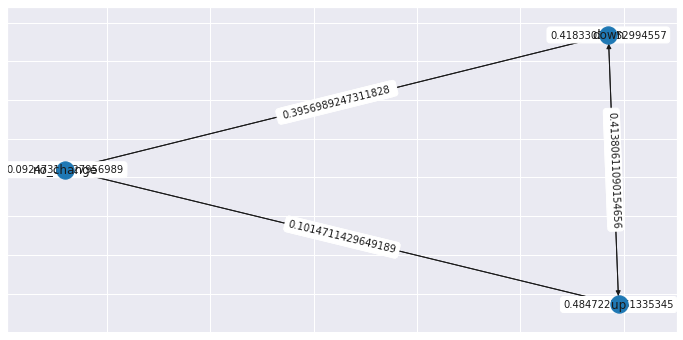

In [18]:
import networkx as nx

states = ['up', 'down', 'no_change']

# create graph object
G = nx.MultiDiGraph()

# nodes correspond to states
G.add_nodes_from(state_space_matrix)
print(f'Nodes:\n{G.nodes()}\n')

# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
pprint(pd.DataFrame(G.edges(data=True)))    

plt.figure(figsize=(12,6))
pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
print(nx.draw_networkx(G, pos))

# create edge labels for jupyter plot but is not necessary
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'nasdaq_markov.dot')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                        Markov Switching Model Results                        
Dep. Variable:                returns   No. Observations:                 2500
Model:               MarkovRegression   Log Likelihood                7996.916
Date:                Sat, 27 Feb 2021   AIC                         -15969.832
Time:                        11:20:03   BIC                         -15899.943
Sample:                             0   HQIC                        -15944.459
                               - 2500                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      7.913      0.000       0.001       0.002
sigma2      2.812e-05   3.96e-06      7.100      0.0

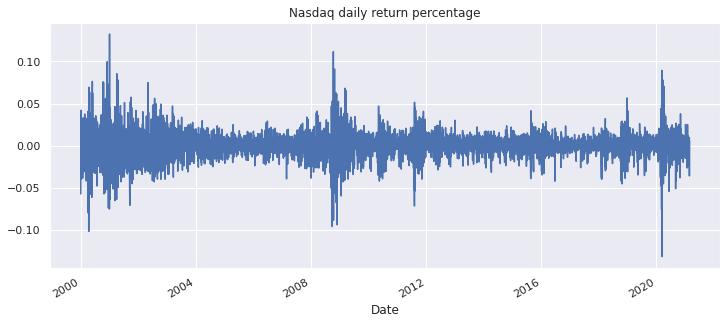

In [19]:
import statsmodels.api as sm

# Plot the data
data['returns'].plot(title='Nasdaq daily return percentage', figsize=(12,5))

data.dropna(inplace=True)

model = sm.tsa.MarkovRegression(data['returns'][-2500:], k_regimes=3,
                                switching_variance=True)


# launch the modelling process on the dataset
np.random.seed(123)
res_1 = model.fit(search_reps=50)

"""We specify that 50 random perturbations from the starting parameter 
vector are examined and the best one used as the actual starting parameters. 

Because of the random nature of the search, the random seed generator 
beforehand allow replication of the result"""

print(res_1.summary())

In [20]:
pred_1 = res_1.predict()
pred_1 = pd.DataFrame(pred_1).tail(20)
pred_1.rename(columns ={0: 'Predicted'}, inplace=True)
com_1 = pd.concat([pred_1, data['returns'].tail(20)], axis=1)
com_1 = com_1.reset_index()
com_1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,returns
0,2021-01-29,0.000110,-0.020182
1,2021-02-01,0.000117,0.025135
2,2021-02-02,0.000248,0.015501
3,2021-02-03,0.000626,-0.000165
4,2021-02-04,0.000798,0.012210
5,2021-02-05,0.001101,0.005686
6,2021-02-08,0.001251,0.009434
7,2021-02-09,0.001391,0.001433
8,2021-02-10,0.001428,-0.002514
9,2021-02-11,0.001422,0.003803


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['returns'],
                         name="Actual returns"))

fig.add_trace(go.Scatter(x=com_1['Date'],y=com_1['Predicted'],
                         name="Predicted return"))

fig.update_layout(title="Nasdaq Actual vs Predicted returns",
   yaxis_title="Price ($)",
    font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=400,)
fig.update_layout(legend_orientation="h")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

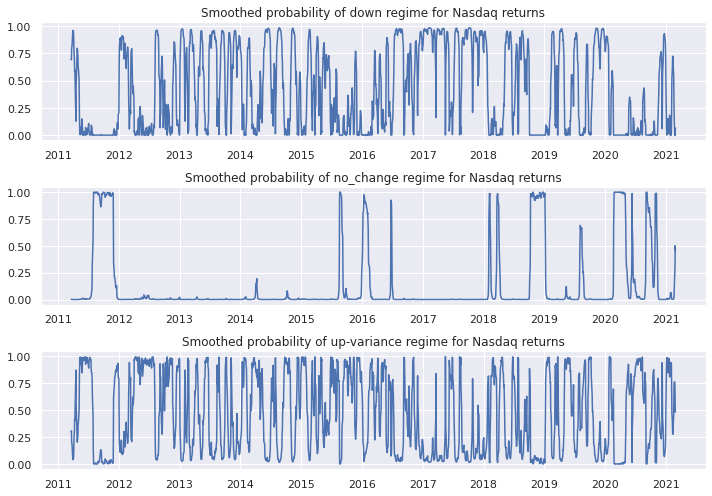

In [22]:
fig, axes = plt.subplots(3, figsize=(10,7))
ax = axes[0]
ax.plot(res_1.smoothed_marginal_probabilities[0])
#ax.fill_between(data['returns'].index, 0,  where=data['returns'].values, color='gray', alpha=0.3)
ax.set(title='Smoothed probability of down regime for Nasdaq returns')
ax = axes[1]
ax.plot(res_1.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of no_change regime for Nasdaq returns')
ax = axes[2]
ax.plot(res_1.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of up-variance regime for Nasdaq returns')
fig.tight_layout()

In [23]:
print(res_1.expected_durations)

[12.29398295 21.10069834 11.28917283]


In [24]:
data['volume_gap'] = np.log(data['Volume'] / data['Volume'].shift()) 
data['daily_change'] = (data['Adj Close'] - data['Open']) / data['Open']
data['fract_high'] = (data['High'] - data['Open']) / data['Open']
data['fract_low'] = (data['Open'] - data['Low']) / data['Open']
data['forecast_variable'] = (data['Adj Close'].shift(-1) - data['Open'])
data.dropna(inplace=True)
data = data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
endog = data['forecast_variable'][-2500:]
exog = data [['volume_gap', 'daily_change', 'fract_high', 'fract_low']][-2500:]


In [25]:
# Fit the 2-regime model
mod_2 = sm.tsa.MarkovRegression(
    endog=endog, k_regimes=3, exog=exog)
res_2 = mod_2.fit(search_reps=50)
print(res_2.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                        Markov Switching Model Results                        
Dep. Variable:      forecast_variable   No. Observations:                 2500
Model:               MarkovRegression   Log Likelihood              -14335.934
Date:                Sat, 27 Feb 2021   AIC                          28715.869
Time:                        11:20:20   BIC                          28843.998
Sample:                             0   HQIC                         28762.386
                               - 2500                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.1946      9.394      2.788      0.005       7.783      44.606
x1           -10.4767     36.244     -0.289      0.7

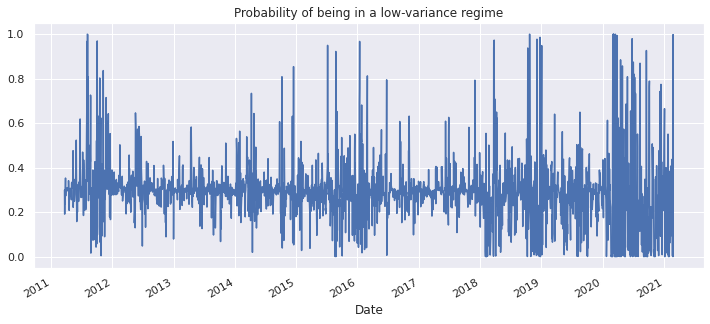

In [26]:
res_2.smoothed_marginal_probabilities[0].plot(
    title='Probability of being in a low-variance regime', figsize=(12,5));

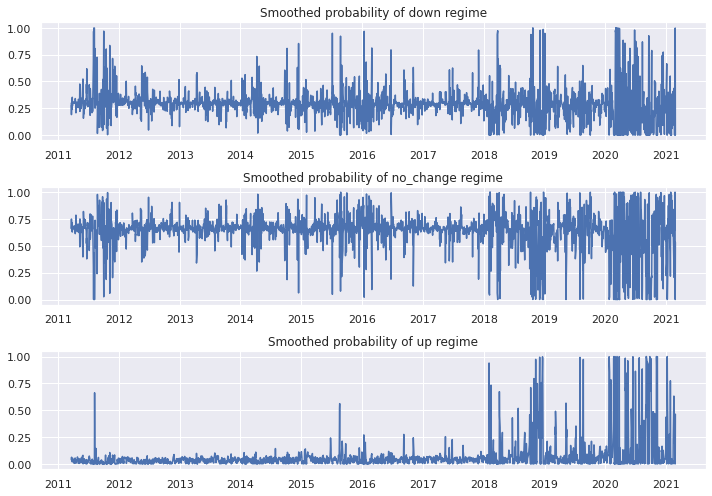

In [27]:
fig, axes = plt.subplots(3, figsize=(10,7))

ax = axes[0]
ax.plot(res_2.smoothed_marginal_probabilities[0])
ax.set(title='Smoothed probability of down regime')

ax = axes[1]
ax.plot(res_2.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of no_change regime')

ax = axes[2]
ax.plot(res_2.smoothed_marginal_probabilities[2])
ax.set(title='Smoothed probability of up regime')

plt.tight_layout()

In [28]:
!pip install probscale
import probscale

     |████████████████████████████████| 440kB 9.9MB/s 


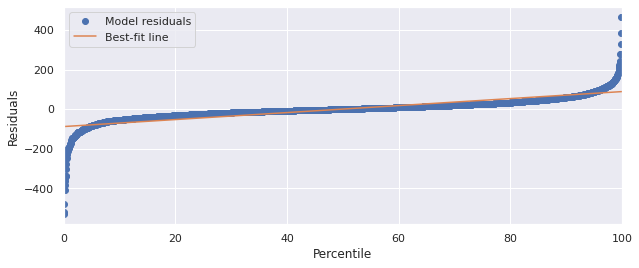

In [29]:
#qqpolot vs. normal distribution
fig, ax = plt.subplots(figsize=(10, 4))
plt.grid(True)
fig = probscale.probplot(res_2.resid, ax=ax, plottype='pp', bestfit=True,
                         problabel='Percentile', datalabel='Residuals',
                         scatter_kws=dict(label='Model residuals'),
                         line_kws=dict(label='Best-fit line'))
ax.legend(loc='upper left')
plt.show()

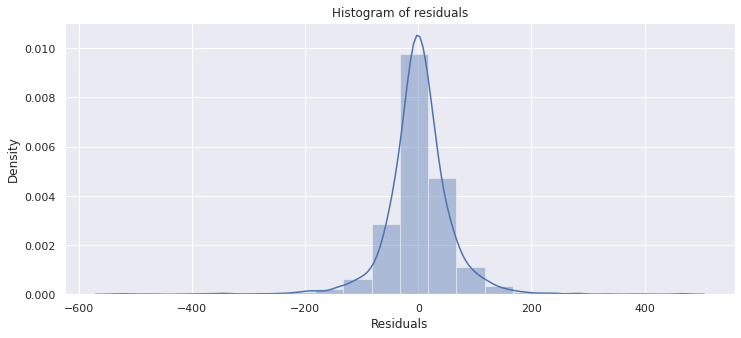

In [30]:
import seaborn as sns
plt.figure(figsize=(12,5))

# Plot a simple histogram with binsize determined automatically
sns.distplot(res_2.resid, 20)
plt.title('Histogram of residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [31]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

name = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
results1 = sms.acorr_breusch_godfrey(res_2, 10)
print(lzip(name, results1))

name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
JB, JBpv,skw,kurt = sm.stats.stattools.jarque_bera(res_2.resid)
print(lzip(name, results1))

[('Lagrange multiplier statistic', 112.88737216814587), ('p-value', 1.3943897164062635e-19), ('f-value', 9.822921389408823), ('f p-value', 2.7378532675456925e-16)]
[('Jarque-Bera', 112.88737216814587), ('Chi^2 two-tail prob.', 1.3943897164062635e-19), ('Skew', 9.822921389408823), ('Kurtosis', 2.7378532675456925e-16)]


In [32]:
print(res_2.expected_durations)

[1.59312795 3.28165736 1.82554756]


In [33]:
print(res_2.conf_int())

                     0             1
p[0->0]      -0.047998      0.792606
p[1->0]       0.189797      0.315429
p[2->0]       0.100687      0.484660
p[0->1]       0.246244      0.954689
p[1->1]       0.687011      0.703541
p[2->1]       0.033410      0.476805
const[0]      7.782877     44.606398
const[1]    -10.221607      4.270348
const[2]   -104.823615     54.081006
x1[0]       -81.512868     60.559443
x1[1]       -44.887764     12.270015
x1[2]       -57.295146     91.448524
x2[0]     -7065.467763  -2467.980960
x2[1]      9085.152286  12498.222934
x2[2]     -9931.514527   4669.407131
x3[0]     -2713.480935  12499.129855
x3[1]     -6715.966621  -3454.640885
x3[2]      5760.166929  28021.853380
x4[0]    -10668.482352  -4855.129750
x4[1]      4921.275915   6862.660573
x4[2]    -22783.807436  -7410.699421
sigma2     3993.833957   4905.825978


In [34]:
predict = res_2.predict()
predict = pd.DataFrame(predict.tail(20))
predict.rename(columns ={0: 'Predicted'}, inplace=True)
predict.rename(columns ={0: 'Predicted'}, inplace=True)
combine = pd.concat([predict, data['forecast_variable'].tail(20)], axis=1)
combine = combine.reset_index()
combine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Date,Predicted,forecast_variable
0,2021-01-28,-57.099151,-252.599609
1,2021-01-29,-54.801215,118.669922
2,2021-02-01,105.826650,386.600586
3,2021-02-02,24.860455,67.440430
4,2021-02-03,-24.408813,59.430664
5,2021-02-04,55.176299,182.240234
6,2021-02-05,26.146304,162.759766
7,2021-02-08,24.391720,70.640625
8,2021-02-09,12.607867,5.709961
9,2021-02-10,-27.110787,-67.580078


In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=combine['Date'],y=combine['forecast_variable'],
                         name="Actual Values (Adj Close"))

fig.add_trace(go.Scatter(x=combine['Date'],y=combine['Predicted'],
                         name="Predicted return"))

fig.update_layout(title="Nasdaq Actual vs Predicted values",
   yaxis_title="Price ($)",
    font=dict(family="Courier New, monospace",size=18,color="#7f7f7f"))
fig.update_layout(autosize=False,width=800,height=500,)
fig.update_layout(legend_orientation="h")
fig.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>